## Initialization

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import random
import numpy as np
import pickle
import torch.nn.functional as F
from copy import deepcopy
from multiprocessing import Pool
from tqdm.notebook import tqdm

#from ENV import KYenv
from ENV import DHenv as Env
from DRQN_controller import DRQN_Agent
from DRQN_learner import QLearner
from DRQN_agent import decode_act,get_decay

import matplotlib.pyplot as plt

### Initiliaze environments

In [3]:
test_ues = torch.tensor([[ 2.3219, 35.5963],
        [ 4.9058,  7.3772],
        [34.1434, 24.6237],
        [30.3456, 22.6246],
        [26.9648, 20.9890],
        [19.2420, 32.8353],
        [12.3929, 39.7321],
        [ 5.9339, 29.5289],
        [33.2905, 37.5042],
        [ 9.2728, 15.3940]])

test_env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = test_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [5]:
envs = []


for s in tqdm(range(100)):
    set_seed(s)
#     t_aps = torch.rand(k)
    t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
    env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = t_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )
    envs.append(env)

  0%|          | 0/100 [00:00<?, ?it/s]

### Initialize models

In [9]:
inter_file_name = 'AP4UE10Act5_Individual.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
controller.save('models/' + inter_file_name)
controller.cuda()
meta_controller = deepcopy(controller)
learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64)
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0

### Training

  0%|          | 0/300 [00:00<?, ?it/s]

Current best 12.00 at iteration 11! Saving.... 
Current best 12.00 at iteration 13! Saving.... 
Current best 12.00 at iteration 14! Saving.... 
Current best 16.40 at iteration 33! Saving.... 
Current best 16.47 at iteration 35! Saving.... 


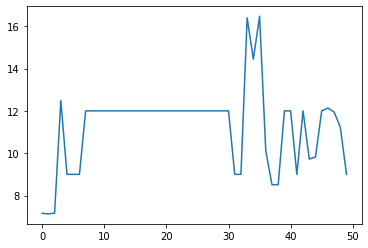

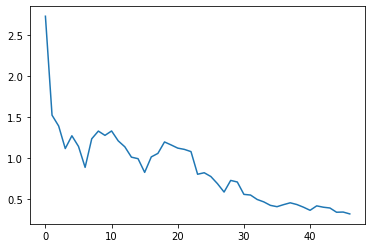

Current best 16.98 at iteration 93! Saving.... 


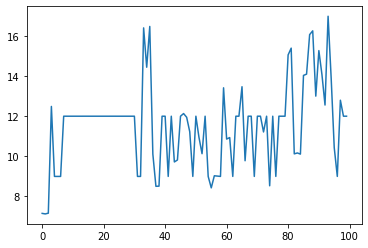

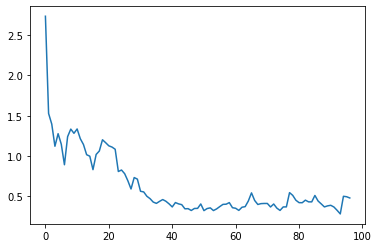

Current best 18.83 at iteration 102! Saving.... 


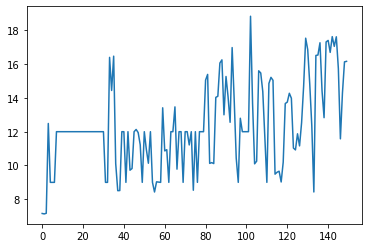

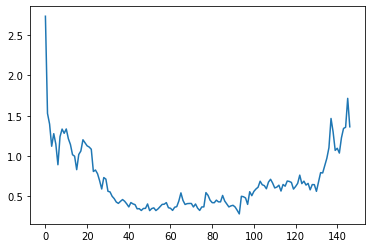

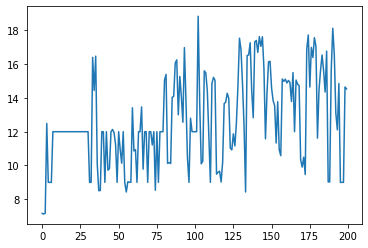

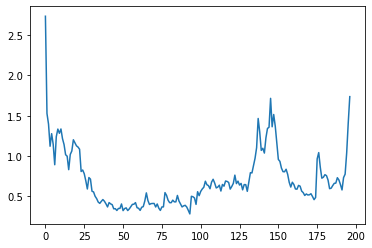

Current best 19.75 at iteration 200! Saving.... 
Current best 20.37 at iteration 219! Saving.... 


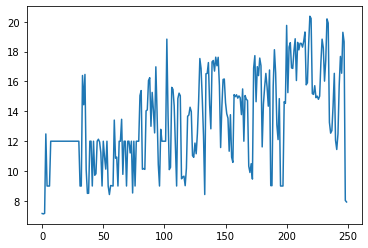

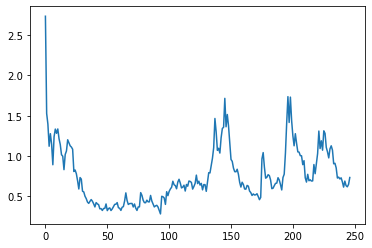

Current best 20.44 at iteration 281! Saving.... 


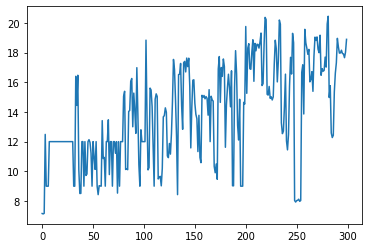

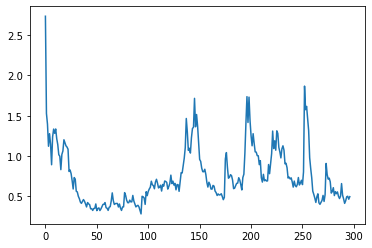

  0%|          | 0/300 [00:00<?, ?it/s]

Current best 13.27 at iteration 11! Saving.... 
Current best 20.07 at iteration 12! Saving.... 


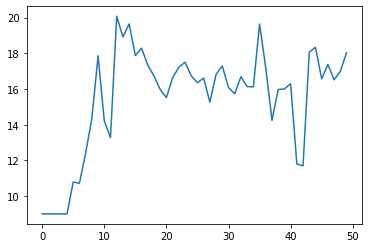

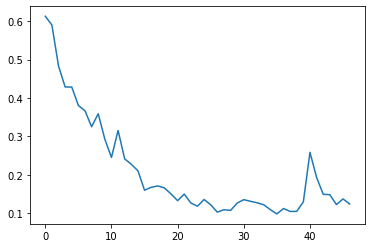

Current best 20.48 at iteration 83! Saving.... 


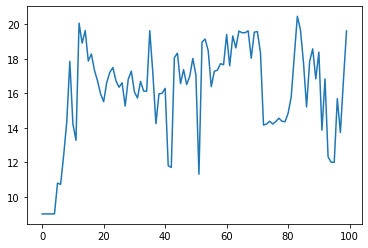

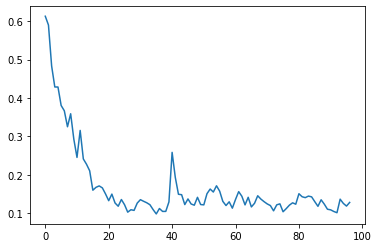

Current best 21.60 at iteration 103! Saving.... 
Current best 21.70 at iteration 104! Saving.... 
Current best 22.18 at iteration 106! Saving.... 


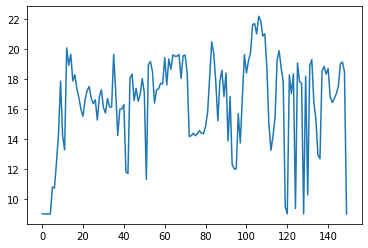

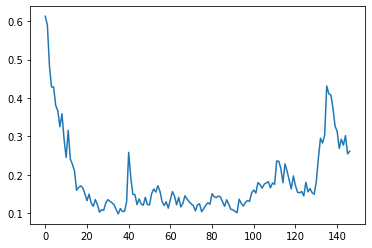

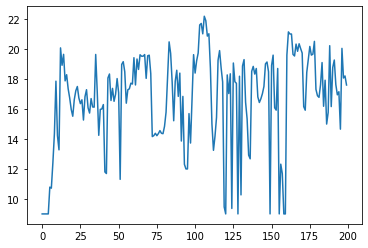

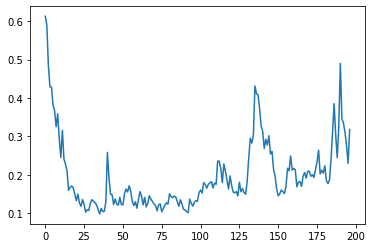

Current best 23.40 at iteration 218! Saving.... 


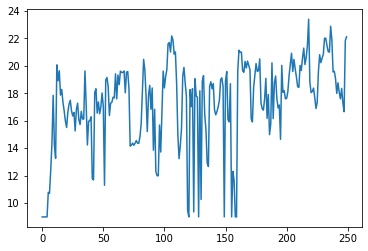

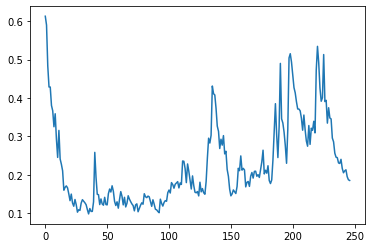

Current best 23.46 at iteration 292! Saving.... 


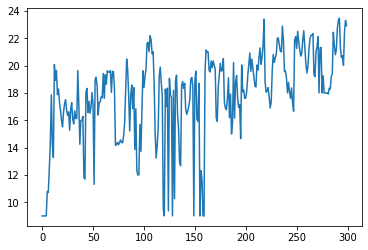

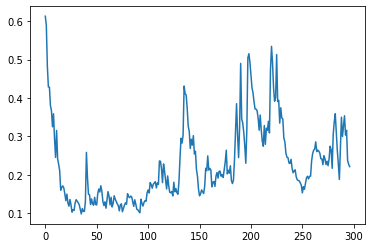

  0%|          | 0/300 [00:00<?, ?it/s]

Current best 20.73 at iteration 11! Saving.... 
Current best 21.65 at iteration 12! Saving.... 


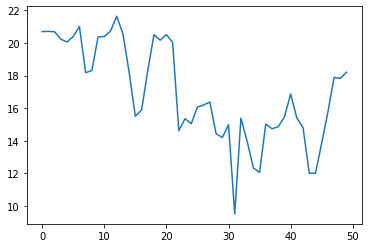

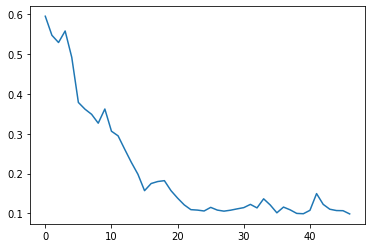

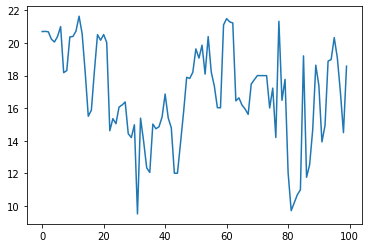

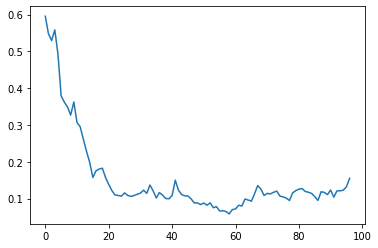

Current best 21.65 at iteration 138! Saving.... 
Current best 21.67 at iteration 139! Saving.... 
Current best 23.10 at iteration 142! Saving.... 
Current best 23.28 at iteration 143! Saving.... 


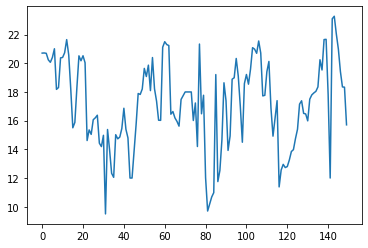

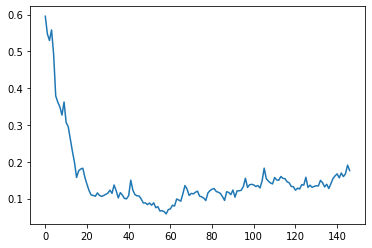

Current best 23.76 at iteration 167! Saving.... 


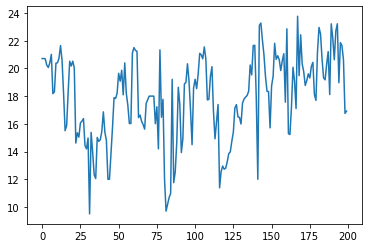

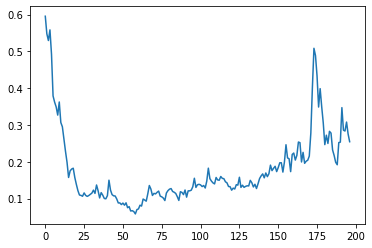

Current best 23.79 at iteration 220! Saving.... 
Current best 24.14 at iteration 225! Saving.... 
Current best 24.93 at iteration 226! Saving.... 
Current best 24.94 at iteration 242! Saving.... 
Current best 25.15 at iteration 247! Saving.... 


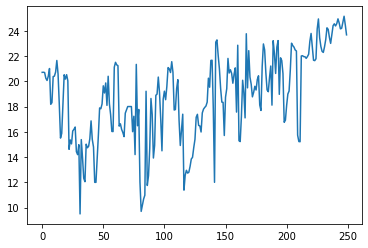

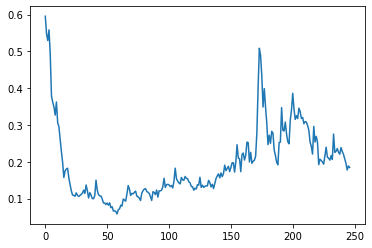

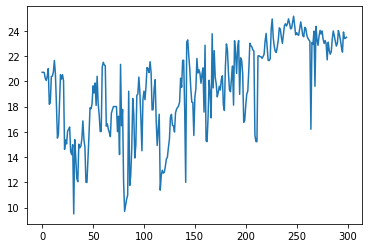

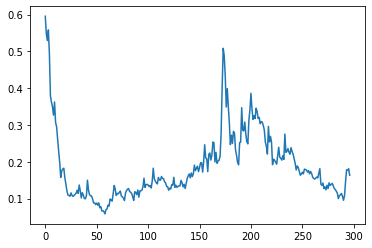

In [11]:
# Defining hyperparams
niterations = 300
max_inner_iter = 64
max_test_iter = 500
outerstepsize0 = 1
# random_seeds = [0,5,3,6,9,14,16,25,22,29]
random_seeds = [35, 40, 45]
k = 0
results_dict = {"loss": None,
               "reward": None}
# pbar = tqdm(range(niterations))
# best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
for k in random_seeds:
    lr = 5e-4
    learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    best = 0
    r_history, loss_history = [], []
    for iteration in pbar:
        env.reset()
        inner_step = 0
        if (iteration + 1) % 100 == 0:
            lr = lr/2
            learner.set_sgd(lr)
        losses = []
    
        for inner_iter in range(max_inner_iter):
            total_step = max_inner_iter * iteration + inner_iter
#         inner_step += 1
            obs = []
#         breakpoint()
            for j in range(env.n_enbs):
                obs.append(env.get_agent_obs(j))
            obs = torch.stack(obs, dim=0)
            obs = torch.flatten(obs)
#         breakpoint()
            cur_obs = obs.reshape(1,64).cuda()
            controller.init_hidden(1)
            action,q = controller.get_action(cur_obs, 1 * (1-iteration/niterations))
            act = decode_act(action,4,5)
            s_t1,r = env.step(act)
            s_t1 = torch.flatten(s_t1)
            controller.init_hidden(512)
            loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
            if loss is not None:
                losses.append(loss.item())
        
        learner._update_targets()
    # Save the results
        if losses != []:
            loss_history.append(np.mean(losses))
    # save and update the test controller
        controller.save('models/' + inter_file_name)
        test_controller.load('models/' + inter_file_name)
        env.reset()
        reward = 0
        for test_iter in range(max_test_iter):
            obs = []
            for j in range(env.n_enbs):
                obs.append(env.get_agent_obs(j))
#         breakpoint()
            obs = torch.stack(obs, dim=0)
            obs = torch.flatten(obs)
            action,_ = test_controller.get_action(
                torch.reshape(obs,(1,64)).cuda(), 0.0)
            act = decode_act(action,4, 5)
            s_t1,r = env.step(act)
            reward += (1 - gamma) * (r - reward)
        r_history.append(reward.item())
        pbar.set_description(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{reward.item():.2f}")
        if reward.item() > best and iteration > 10:
            best = reward.item()
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/drqn_best_centralized_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_centralized_results.pkl", "wb") as file:
                pickle.dump(results_dict, file)
        

### Draw results

In [16]:
with open("./results/env_0_results.pkl", "rb") as file:
            result = pickle.load(file)

In [18]:
import torch
import numpy as np
import torch.nn as nn
import pickle
import os 
import sys
import matplotlib.pyplot as plt

In [62]:
from glob import glob
dirs = glob("./results/*_results*.pkl")
dirs

['./results/env_5_centralized_results.pkl',
 './results/env_0_centralized_results.pkl',
 './results/env_6_centralized_results.pkl']

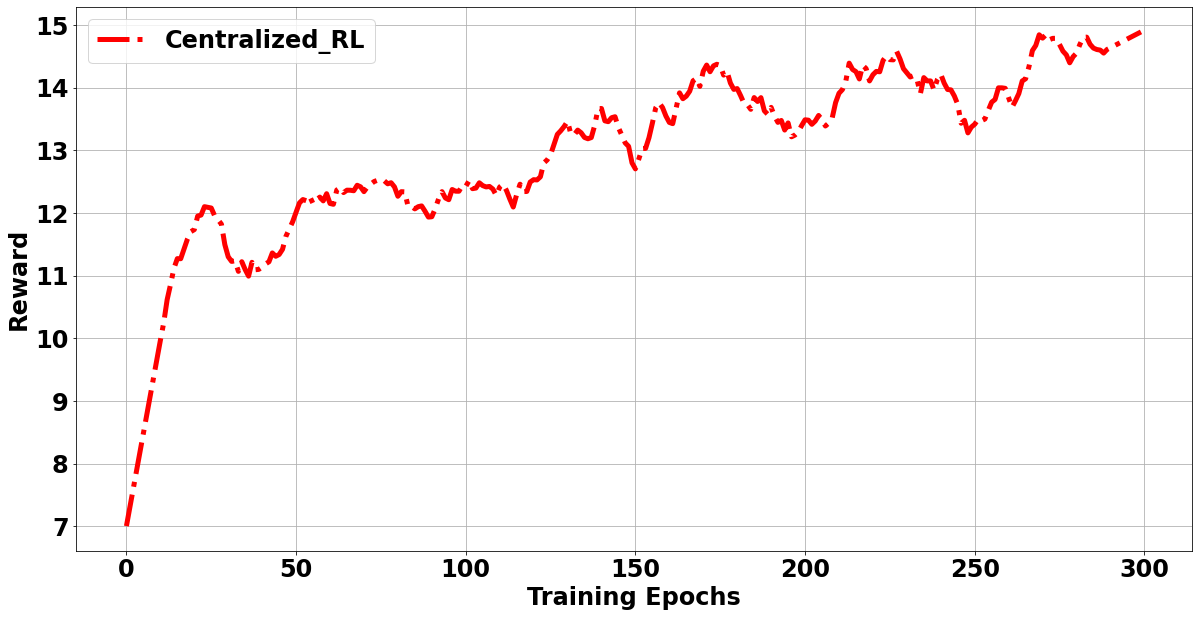

In [63]:
import json
import matplotlib
from scipy.signal import savgol_filter

figure_map= {
    "MARL":["b", "-"],
    "Centralized_RL":["r","-."],
    "Heuristic_baseline":["g",":"]
    
}

font = {'weight' : 'bold',
        'size'   : 24}

results = {}

for i,d in enumerate(dirs):
#     breakpoint()
    d = dirs[i]
    label = dirs[i].split("_")[-2]
    
    
    with open(d, "rb") as f:
#         breakpoint()
        res = pickle.load(f)
        r = res["reward"]
        if label not in results:
            results[label] = np.zeros((len(r),))
            r = np.array(r)
            results[label] += np.array(r)
        else:
            r = np.array(r)
            results[label] += np.array(r)

plt.figure(figsize = (20,10))
if label == "centralized":
    label_n = "Centralized_RL"
plt.plot(savgol_filter(results[label], 21, 1)/len(dirs),c = figure_map[label_n][0],lw=5 ,ls=figure_map[label_n][1], label = label_n)
plt.xlabel("Training Epochs", fontsize=24, weight="bold")
plt.ylabel("Reward", fontsize=24, weight="bold")
matplotlib.rc('font', **font)
plt.grid()
plt.legend()

